# **Question 1**

In [2]:
import cvxpy as cp
import numpy as np
from matplotlib import pyplot as plt

We define control variables for velocity (v) and braking power (pb)

In [71]:
def solution_finder(T, h, xf, vf, V, A, c):
  n = int(T/h)
  def acc(v):
    temp = [[0.0 for i in range(n)] for i in range(n)]
    for j in range(n):
      temp[j][j] = 1.0/h
    for k in range(n-1):
      temp[k+1][k] = -1.0/h
    acc = temp@v
    return acc

  def optimizer(T, h, xf, vf, V, A, c):
    v, pb = cp.Variable(n), cp.Variable(n)    
    E = (c*h*((cp.pnorm(v, 3))**3)) + (v[n-1]**2/2) + (h*cp.sum(pb))
    objective = cp.Minimize(E)
    xn = (h*cp.sum(v[0:n-1])) + (h*v[n-1]/2)
    constraints = [v >= 0.0, v <= V, v[n - 1] <= vf, acc(v) <= A, xn >= xf, pb >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return prob, v, pb

  def x_finder(velocity, h, n) :
    x = []
    for i in range(n):
        x.append((h*velocity[i]/2) + (h*sum(velocity[0:i])))
    return np.array(x)

  def pr_finder(velocity, braking, h, c, n):
    pr = []
    for i in range(n) :
        if i != 0 :
            pr.append((braking[i]) + (c*(velocity[i]**3)) + ((velocity[i]**2 - velocity[i-1]**2)/h))
        else :
            pr.append((braking[i]) + (c*(velocity[i]**3)) + ((velocity[i]**2)/h) )
    return np.array(pr)
  
  solution, Velocity, braking = optimizer(T, h, xf, vf, V, A, c)
  v_array = np.array(Velocity.value)
  x_array = x_finder(Velocity.value, h, n)
  a_array = acc(Velocity.value)
  pr_array = pr_finder(Velocity.value, braking.value, h, c, n)
  Energy = h*sum(pr_array)
  return x_array, v_array, a_array, braking, pr_array, Energy, solution.value

In [92]:
def plot_variable(variable_name, T, h, xf, vf, V, A, c):
  n = int(T/h)

  if (variable_name == 'x'):
    var = solution_finder(T, h, xf, vf, V, A, c)[0]
  elif (variable_name == 'v'):
    var = solution_finder(T, h, xf, vf, V, A, c)[1]
  elif (variable_name == 'pr'):
    var = solution_finder(T, h, xf, vf, V, A, c)[4]
  return var

In [93]:
def vary_xf(variable_name, T, h, xf_array, vf, V, A, c):
  n = len(xf_array)
  plt.rcParams['figure.figsize'] = [12, 8]
  x_range = [i for i in range(int(T / h))]
  for i in range(n):
    var = plot_variable(variable_name, T, h, xf_array[i], vf, V, A, c)
    plt.plot(x_range, var, linestyle = 'dashed', label = xf_array[i])
  plt.legend()
  plt.show()

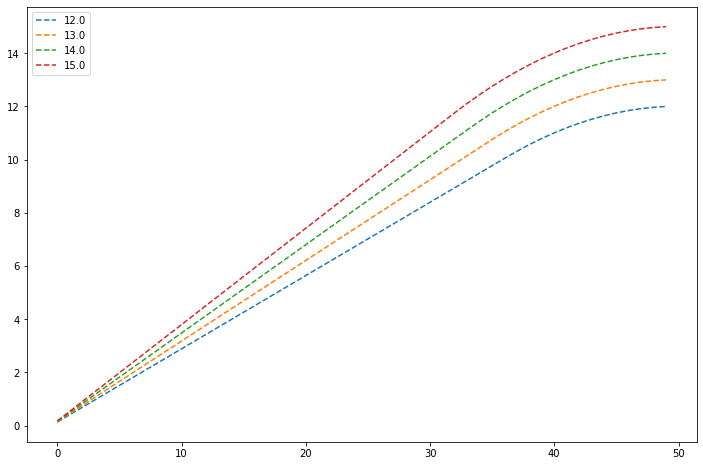

In [94]:
vary_xf('x', 5.0, 0.1, [12.0, 13.0, 14.0, 15.0], 2.0, 10.0, 2.0, 2.0)

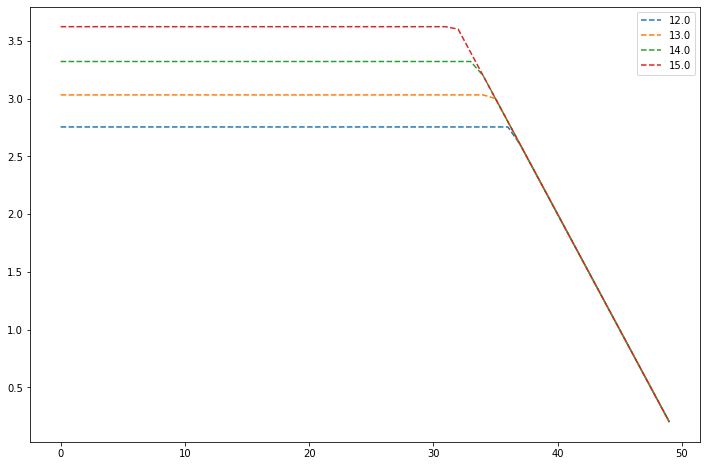

In [95]:
vary_xf('v', 5.0, 0.1, [12.0, 13.0, 14.0, 15.0], 2.0, 10.0, 2.0, 2.0)

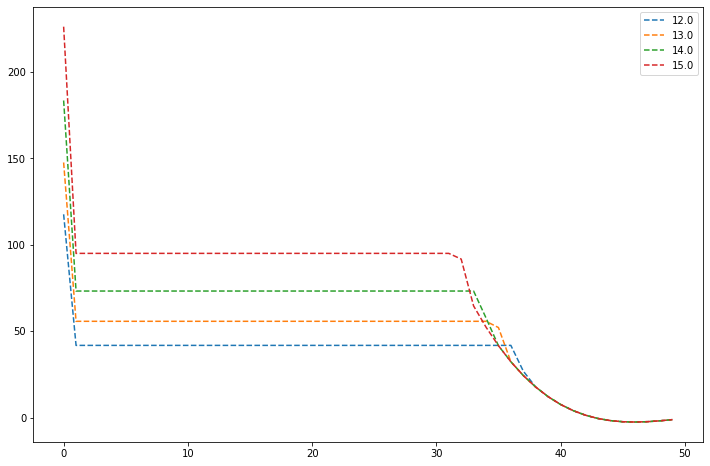

In [96]:
vary_xf('pr', 5.0, 0.1, [12.0, 13.0, 14.0, 15.0], 2.0, 10.0, 2.0, 2.0)

#**Question 2**

In [97]:
import numpy as np
import cvxpy as cp
from cvxpy import Variable, Minimize, Maximize, Problem, square, entr 

In [98]:
def circuita():
	A = np.array([[1,0,0,0,0,0,0,-1],
				[-1,1,0,0,1,0,1,0],
				[0,-1,1,0,0,1,0,0],
				[0,0,-1,1,-1,0,0,0],
				[0,0,0,-1,0,-1,-1,1]], dtype=float)
	R1 = 10.0
	R2 = 100.0
	V = 10.0
	r = 2.0
	i = Variable(8)
	phi = -V*i[7] + 0.5*r*square(i[7]) \
				+ 0.5*R1*square(i[0]) \
				+0.5*R2*square(i[1]) \
				+ 0.5*R1*square(i[2]) \
				+ 0.5*R2*square(i[3]) \
				+ 0.5*R1*square(i[4]) \
				+ 0.5*R2*square(i[5]) \
				+ 0.5*R1*square(i[6])

	# primal
	obj = Minimize(phi)
	constraints = [A @ i == 0.0]
	prob = Problem(obj,constraints)
	prob.solve()

	# dual
	b = prob.constraints[0].dual_value

	v = np.array([R1*i.value[0],
				+R2*i.value[1],
				+R1*i.value[2],
				+R2*i.value[3],
				+R1*i.value[4],
				+R1*i.value[5],
				+R1*i.value[6],
				+r*i.value[7]+V], dtype=float)

	print(" RESULTS FOR Circuit 'a' are:")
	print("Primal optimal i: ",i.value)
	print("Primal optimal v: ",v)

	print("Dual optimal b : ",b)
	print("Dual optimal v : ",(A.T @ -b))


In [99]:
def circuitb():
	A = np.array([[1,0,0,0,0,0,-1],
				[-1,1,0,0,0,1,0],
				[0,-1,1,0,1,0,0],
				[0,0,-1,1,0,0,0],
				[0,0,0,-1,-1,-1,1]], dtype=float)
	R1 = 1000.0
	R2 = 100.0
	V = 1.0
	r = 1.0
	VT = 0.03
	IS = 0.5e-3
	i = Variable(7)
	phi = -V*i[6] + 0.5*r*square(i[6]) \
				+ 0.5*R1*square(i[0]) \
				+0.5*R1*square(i[1]) \
				+ VT*IS*(-entr(1.0+i[2]/IS)-i[2]/IS) \
				+ 0.5*R2*square(i[3]) \
				+ VT*IS*(-entr(1.0+i[4]/IS)-i[4]/IS) \
				+ 0.5*R1*square(i[5]) 

	# primal
	obj = Minimize(phi)
	constraints = [A @ i == 0.0]
	prob = Problem(obj,constraints)
	prob.solve()

	# dual
	b = prob.constraints[0].dual_value

	v = np.array([R1*i.value[0],
				+R1*i.value[1],
				+VT*np.log(1.0+i.value[2]/IS),
				+R2*i.value[3],
				+VT*np.log(1.0+i.value[4]/IS),
				+R1*i.value[5],
				+r*i.value[6]-V], dtype=float)

	print(" RESULTS FOR Circuit 'a' are:")
	print("Primal optimal i : ",i.value)
	print("Primal optimal v : ",v)

	print("Dual optimal b : ",b)
	print("Dual optimal v : ",(A.T @ -b))


In [100]:
circuita()

 RESULTS FOR Circuit 'a' are:
Primal optimal i:  [ 0.4858444   0.00850433 -0.02469     0.03566334  0.06035334  0.03319434
  0.41698672  0.4858444 ]
Primal optimal v:  [ 4.85844398  0.85043345 -0.24690003  3.56633381  0.60353341  0.33194338
  4.16986722 10.9716888 ]
Dual optimal b :  [-5.011522   -0.15307802  0.69735543  0.45045539  4.0167892 ]
Dual optimal v :  [ 4.85844398  0.85043345 -0.24690003  3.56633381  0.60353341  3.31943378
  4.16986722 -9.0283112 ]


In [101]:
circuitb()

 RESULTS FOR Circuit 'a' are:
Primal optimal i :  [6.65230638e-04 3.31125949e-04 7.79256334e-05 7.79259407e-05
 2.53200171e-04 3.34104101e-04 6.65230426e-04]
Primal optimal v :  [ 0.66523064  0.33112595  0.00434511  0.00779259  0.01229169  0.3341041
 -0.99933477]
Dual optimal b :  [-0.72862523 -0.06340075  0.25839936  0.2629173   0.27070953]
Dual optimal v :  [ 0.66522447  0.32180012  0.00451794  0.00779223  0.01231017  0.33411029
 -0.99933476]
